In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
from scipy.stats import skewnorm
import scipy as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [20]:
def dataimporter(filename,header=77,undregräns_b=2,övregränds_b=2.7):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    data = nummerdata
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    return nummerdata


def dataimporterclean(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata

def bakgrund(x,c1,c2):
    return c1*x+c2

def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration(data,under=2,over=2.8,marginal=0.1):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))[0][0]
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))[0][0]
        x=i[intunder:intover,0]
        y = i[intunder:intover,1]
        
        mitten = x[np.argmax(y)]

        u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
        ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
        x=x[u:ö]
        y = y[u:ö]

        poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
        
        top1 =  np.sum(norm(x,*poptnorm))
        array = np.append(array,top1)
    return array


def data_integrationold(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def skew_normal(x, a, loc, scale,amp):
    return amp*skewnorm.cdf(x, a, loc=loc, scale=scale)

def skew_normal_pdf(x, a, loc, scale,amp):
    return amp*skewnorm.pdf(x, a, loc=loc, scale=scale)
def norm(x,a,mean,sigma):
    return a*stats.norm.pdf(x,mean,sigma)

def invnorm(x,a,mean,sigma):
    return a*stats.invgauss.pdf(x,mean,sigma)

In [59]:
spectraldata5keVhelios = pd.DataFrame(columns=["tcps","thickness"])

J1 = readfile(["J1_bulk_pt1.psmsa"])
spectraldata5keVhelios.loc["G10_2"] = [J1[0],0]

G10_2 = readfile(["G10_2_pt1.psmsa"])
spectraldata5keVhelios.loc["G10_2"] = [G10_2[0],10]

G10_1 = readfile(["G10_thinnest_pt1.psmsa"])
spectraldata5keVhelios.loc["G10_1"] = [G10_1[0],60]

zero = readfile(["Background_pt1.psmsa"])
spectraldata5keVhelios.loc["zero"] = [zero[0],0]

C6 = readfile(["C6_pt1.psmsa"])
spectraldata5keVhelios.loc["C6"] = [C6[0],20]

D2_1 = readfile(["D2_bilayermabey_area2_pt1.psmsa"])
spectraldata5keVhelios.loc["D2_1"] = [D2_1[0],30]

D2_2 = readfile(["D2_thinn_Area1_pt1.psmsa"])
spectraldata5keVhelios.loc["D2_2"] = [D2_2[0],40]

F1 = readfile(["F1_pt1.psmsa"])
spectraldata5keVhelios.loc["F1"] = [F1[0],40]

N10 = readfile(["N10_thick_area1_pt1.psmsa"])
spectraldata5keVhelios.loc["N10"] = [N10[0],100]

N10_2 = readfile(["N10_thick_area2_pt1.psmsa"])
spectraldata5keVhelios.loc["N10_2"] = [N10_2[0],100]

print(spectraldata5keVhelios)

              tcps  thickness
G10_2   136.629895       10.0
G10_1   117.244931       60.0
zero     10.766292        0.0
C6      915.856095       20.0
D2_1    205.580917       30.0
D2_2    -22.642742       40.0
F1      927.479848       40.0
N10    5419.407261      100.0
N10_2  2523.246132      100.0


In [56]:
x_before = spectraldata5keVhelios["thickness"].to_numpy()*10**9
y_after = spectraldata5keVhelios["tcps"].to_numpy()

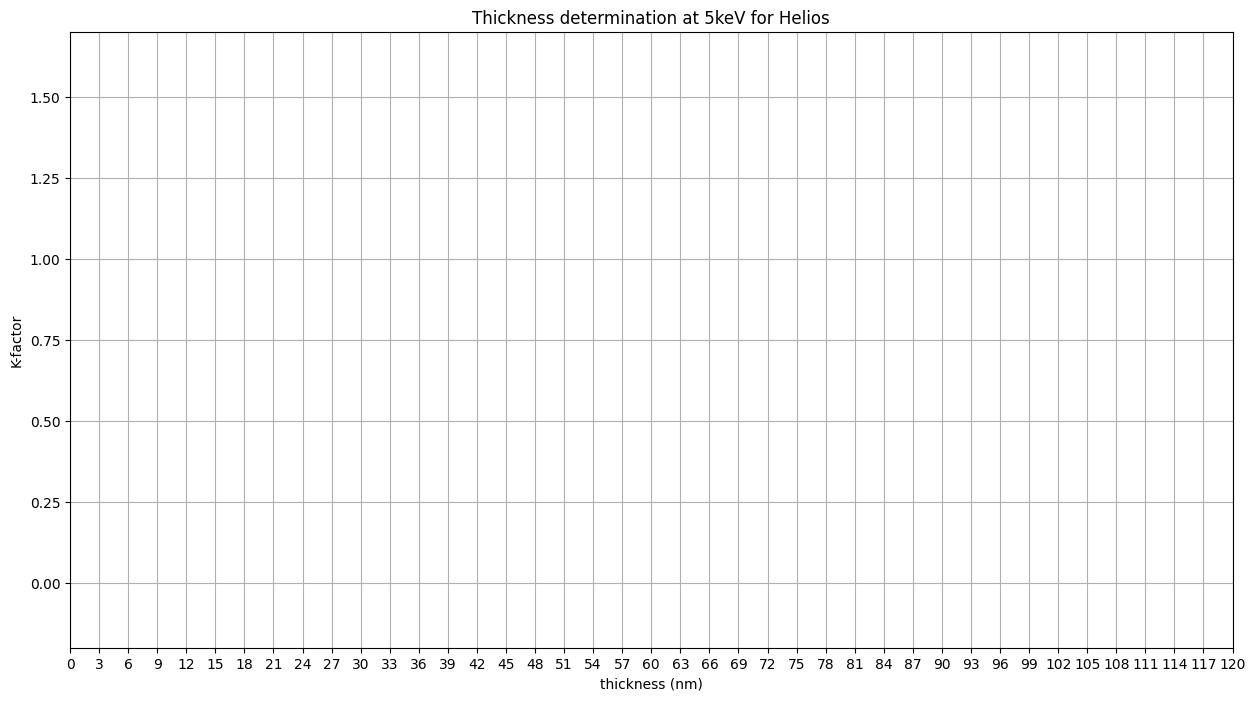

In [58]:
x = x_before
y = y_after

thi = np.linspace(0,700,1000)

con10 = np.polyfit(x[:-1],y[:-1],1)
#Skew normal analasys
# poptry,pcov = sp.optimize.curve_fit(skew_normal,xdata=np.concatenate((x[:8],x[9:])),ydata=np.concatenate((y[:8],y[9:])),p0=[0.001,1,277.86757077762036,1])
popt,pcov = sp.optimize.curve_fit(skew_normal,xdata=x,ydata=y,p0=[0.001,1,277.86757077762036,1])

fig, ax = plt.subplots(1)
fig.set_size_inches(15,8)
# Plotting for 5keV model
ax.scatter(x*10**-9,y,color= "black",zorder = 4)
# ax.errorbar(spectraldata10points["thickness"].to_numpy()*10**9,spectraldata10points["tcps"].to_numpy(),yerr = spectraldata10points["tcpserror"].to_numpy(),xerr= spectraldata10points["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
ax.plot(thi,con10[0]*thi+con10[1],color = "red",zorder = 2)
# ax.plot(thi,skew_normal(thi,*popt))
# ax.plot(thi,skew_normal(thi,*poptry))
# ax.scatter(x[8],y[8],zorder=20,color="yellow")

# ax.scatter(spectraldata5keVhelios["thickness"],spectraldata5keVhelios["tcps"],zorder=20)


ax.set_xlabel("thickness (nm)")
ax.set_ylabel("K-factor")
ax.xaxis.set_major_locator(ticker.MaxNLocator(40))
ax.grid(zorder=1)
# ax[i].legend()
ax.set_ylim((-0.2,1.7))
# ax.set_xlim((-1,300))
ax.set_title("Thickness determination at 5keV for Helios")
ax.set_xlim((0,120))
# ax.set_ylim((-0.05,1.7))
plt.show()